# Analyzing Lab Tests

We analyze the availability of selected laboratory tests.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from collections import Counter
from pprint import pprint

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
path_figures = Path('../../figures/')

miiv_path = '~/Documents/data/ts/miiv/fully_observed/miiv_ts_wide.csv.gz'
miiv_path_p = '~/Documents/data/ts/miiv/fully_observed/miiv_ts_wide.parquet'
# df = pd.read_csv(miiv_path)
df = pd.read_parquet(miiv_path_p)
df['time'] = df['time'].apply(lambda x: x.total_seconds() / 60 / 60)
df.head()

,id,time,label,alb,alp,alt,ast,be,bicar,bili,...,phos,plt,po2,ptt,resp,sbp,temp,tnt,urine,wbc
0,30000153,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.0,124.5,36.000000,NaN,280.0,NaN
1,30000153,1.0,False,NaN,NaN,NaN,NaN,-3.0,NaN,NaN,...,NaN,NaN,242.0,NaN,16.0,141.0,37.277778,NaN,45.0,NaN
2,30000153,2.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN
3,30000153,3.0,False,NaN,NaN,NaN,NaN,-4.0,19.0,NaN,...,3.1,173.0,215.0,25.3,14.0,116.0,37.500000,NaN,50.0,17.0
4,30000153,4.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,20.0,111.0,NaN,NaN,45.0,NaN


In [32]:
grouped = df.groupby('id')

# Define Tests

In [77]:
test_variables = {
        'CBC': ['hgb', 'mcv', 'mch', 'mchc', 'plt', 'wbc'],
        'CBC+diff': ['hgb', 'mcv', 'mch', 'mchc','wbc','plt','lymph','neut'],
        'BMP': ['glu', 'bun', 'bicar', 'crea', 'na', 'k', 'cl', 'ca'],
        'CMP': ['glu', 'bun', 'bicar', 'crea', 'na', 'k', 'cl', 'ca', 'alb', 'bili', 'alp', 'ast', 'alt'],
        'ABG': ['ph', 'pco2', 'po2']
}

# TODO: add test hierarchy



test_costs = {
        'CBC': 10,
        'CBC+diff': 12,
        'BMP': 13,
        'CMP': 15,
        'ABG': 28
}

In [56]:
def analyze_test(df: pd.DataFrame, test_variables: dict):
    test_num_dict = {}
    for test_name, test_vars in test_variables.items():
        # print(test_vars)
        d = df[test_vars]
        d = ~d.isna()
        test_num = d.all(axis=1).sum()
        # print(d, flush=True)
        # break
        test_num_dict[test_name] = test_num
        # print(test_name, test_num)
    return test_num_dict

    
    

In [93]:
def calc_costs(test_nums: dict, test_costs: dict):
    total_costs = 0
    cost_dict = {}
    for test_name, test_num in test_nums.items():
        costs = test_num * test_costs[test_name]
        cost_dict[test_name] = costs
        total_costs += costs
    cost_dict = {'total': total_costs, **cost_dict} # total should be first item
    
    return cost_dict

In [78]:
test_num_dict_total = Counter({key:0 for key in test_variables.keys()})

for name, data in tqdm(grouped):
    temp_dict = analyze_test(data, test_variables)
    # pprint(temp_dict)
    test_num_dict_total += Counter(temp_dict)
    
    
cost_dict = calc_costs(dict(test_num_dict_total), test_costs)

pprint(test_num_dict_total)
pprint(dict(test_num_dict_total))
    

100%|██████████| 67056/67056 [01:51<00:00, 602.58it/s]


NameError: name 'calc_costs' is not defined

In [92]:
cost_dict = calc_costs(dict(test_num_dict_total), test_costs)
print(cost_dict)

{'total': 10291160, 'CBC': 2266360, 'BMP': 2709291, 'ABG': 4604068, 'CBC+diff': 372096, 'CMP': 339345}


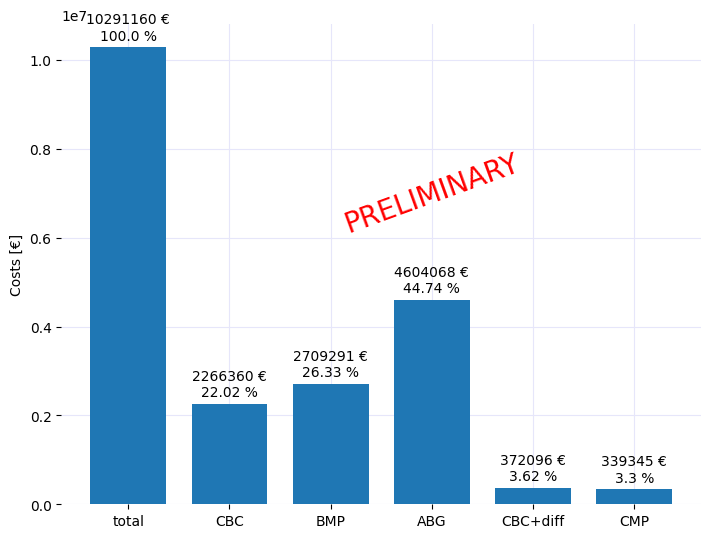

In [124]:
values = list(cost_dict.values())
labels = list(cost_dict.keys())
positions = np.arange(len(labels))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(positions, values, width=0.75, zorder=2)
ax.set_xticks(positions, labels)
ax.grid(visible=True, color='lavender')
ax.spines[:].set_visible(False)
ax.set_ylabel('Costs [€]')

# show percentage in each bar
for i, v in enumerate(values):
    # total number
    # ax.text(i, v, str(v), ha='center', va='bottom', color='black')
    # percentage
    number = f'{str(v)} €'
    percentage = f'{round(v / cost_dict["total"] * 100, 2)} %'
    # ax.text(i, v + 600000, number, ha='center', va='bottom', color='black')
    # ax.text(i, v + 100000, percentage, ha='center', va='bottom', color='black')
    ax.text(i, v + 100000, f'{number}\n{percentage}', ha='center', va='bottom', color='black', rotation=0)

ax.text(3, 6000000, 'PRELIMINARY', color='red', fontsize=20, ha='center', va='bottom', rotation=20)

plt.savefig(path_figures / 'miiv_lab_costs.pdf', bbox_inches='tight')
plt.show()
